In [1]:
IMAGES_LOCATION = "/home/kostrovy/data/x_ray/train"
TEST_IMAGES = "/home/kostrovy/data/x_ray/test"
IMG_HEIGHT= 224
IMG_WIDTH = 224
BATCH_SIZE = 16

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path


import imageio
import cv2
import skimage.transform

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, recall_score, accuracy_score

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def img_class(cl):
    if np.round(cl[0]) == 1:
        return 0
    else:
        return 1 

In [7]:
def create_label(label):
    #print(label)
    return label
    if label == 'red':
        return 1
    else:
        return 0

In [8]:
plt.style.use('fivethirtyeight')
toy=False

In [9]:
files =[]
for r, d, f in os.walk(IMAGES_LOCATION):
    for file in f:
        files.append(os.path.join(r,file))

In [10]:
images = pd.DataFrame(files)
images.columns = ['path']
#images['label'] = images.path.apply(lambda x:create_label(x.split('/')[-2]) )
images['label'] = images.path.apply(lambda x:x.split('/')[-2] )

In [11]:
images.shape

(5233, 2)

In [12]:
normal = images[images.label == 'NORMAL']

In [13]:
normal.head()

,path,label
1,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
2,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
3,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
4,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
5,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL


In [14]:
len(normal)

1349

In [15]:
pnemonia = images[images.label =='PNEUMONIA']
pnemonia.head()
len(pnemonia)

3883

In [16]:
print(len(normal),len(pnemonia))

1349 3883


In [17]:
df = pd.concat([normal,pnemonia])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,path,label
0,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
1,/home/kostrovy/data/x_ray/train/NORMAL/NORMAL-...,NORMAL
2,/home/kostrovy/data/x_ray/train/PNEUMONIA/BACT...,PNEUMONIA
3,/home/kostrovy/data/x_ray/train/PNEUMONIA/BACT...,PNEUMONIA
4,/home/kostrovy/data/x_ray/train/PNEUMONIA/VIRU...,PNEUMONIA


(1302, 1518)


Text(0.5, 1.0, 'NORMAL')

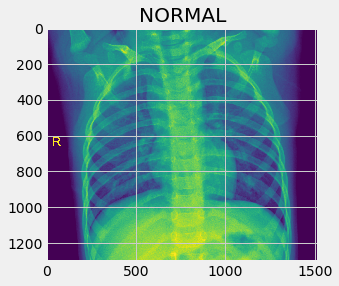

In [18]:
import matplotlib.image as mpimg
numb= np.random.randint(0,df.shape[0])
img = mpimg.imread(df.loc[numb]['path'])

print(img.shape)
plt.imshow(img)
plt.title(df.loc[numb]['label'])

In [19]:
df_train, df_test = train_test_split(df, random_state=42)
print(df_train.shape, df_test.shape)

(3924, 2) (1308, 2)


# CREATE TEST FILES FOR FINAL TESTING 

Text(0.5, 1.0, 'NORMAL')

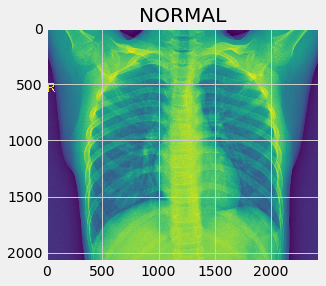

In [20]:
test_files =[]
for r, d, f in os.walk(TEST_IMAGES):
    for file in f:
        test_files.append(os.path.join(r,file))
test_images = pd.DataFrame(test_files)
test_images.columns = ['path']
test_images['label'] = images.path.apply(lambda x:create_label(x.split('/')[-2]) )
test_images.drop(0, axis=0,inplace=True)
test_images.loc[1,'path']
img = mpimg.imread(test_images.loc[2,'path'])
plt.imshow(img)
plt.title(test_images.loc[1,'label'])

In [21]:
img.shape

(2076, 2426)

In [22]:
datagen_model_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [23]:
#test_img_generator=datagen_model_test.flow_from_dataframe(
test_img_generator=datagen_model_test.flow_from_directory(
    TEST_IMAGES, 
    batch_size=624,
    target_size=(IMG_HEIGHT,IMG_HEIGHT),
    seed=42)

Found 624 images belonging to 2 classes.


# Create Data generators for training 

In [24]:
datagen_train=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    #validation_split=0.25
    )
datagen_test = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [25]:
train_generator=datagen_train.flow_from_dataframe(
dataframe=df_train,
x_col="path",
y_col="label",
#subset="training",
batch_size=BATCH_SIZE,
seed=42,
#shuffle=True,
target_size=(IMG_HEIGHT,IMG_HEIGHT)
)

Found 3924 validated image filenames belonging to 2 classes.


In [26]:
valid_generator=datagen_test.flow_from_dataframe(
dataframe=df_test,
x_col="path",
y_col="label",
#subset="validation",
batch_size=BATCH_SIZE,
seed=42,
#shuffle=True,
#class_mode="binary",
target_size=(IMG_HEIGHT,IMG_HEIGHT)
)

Found 1308 validated image filenames belonging to 2 classes.


In [27]:
CLASSES = 2
base_model = VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
#base_model = VGG19(include_top=False, input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
#base_model = Xception(include_top=False,weights='imagenet', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3))
#base_model = Xception(include_top=False,weights='imagenet', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3))

In [28]:
for i,j in valid_generator:
    print(i.shape,j.shape)
    break

(16, 224, 224, 3) (16, 2)


In [29]:
#CLASSES = 2

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(units=512,activation="relu")(x)
#x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=predictions)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
#for layer in base_model.layers:
#    layer.trainable = True
base_model.trainable = False

In [32]:
metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()]
#opt = Adam(lr=0.000001)
#opt = SGD(lr=0.00001)
#model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0000001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.Adam(),
#                            loss=tf.keras.losses.BinaryCrossentropy(),
#                            metrics=['accuracy']
#                            )
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [33]:
EPOCHS = 10
STEPS_PER_EPOCH = 200
VALIDATION_STEPS = 32
MODEL_FILE = 'filename.model'

history = model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)

Epoch 1/10
200/200 [==============================] - 46s 216ms/step - loss: 0.8467 - recall: 0.7011 - accuracy: 7.7404e-04 - val_loss: 0.2505 - val_recall: 0.9434 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 42s 211ms/step - loss: 0.3260 - recall: 0.8819 - accuracy: 0.0093 - val_loss: 0.2250 - val_recall: 0.9277 - val_accuracy: 9.7656e-04
Epoch 3/10
200/200 [==============================] - 42s 211ms/step - loss: 0.2854 - recall: 0.9018 - accuracy: 0.0192 - val_loss: 0.2678 - val_recall: 0.9180 - val_accuracy: 0.0029
Epoch 4/10
200/200 [==============================] - 42s 211ms/step - loss: 0.2536 - recall: 0.9053 - accuracy: 0.0266 - val_loss: 0.1877 - val_recall: 0.9316 - val_accuracy: 9.7656e-04
Epoch 5/10
200/200 [==============================] - 42s 211ms/step - loss: 0.2422 - recall: 0.9171 - accuracy: 0.0398 - val_loss: 0.2307 - val_recall: 0.9199 - val_accuracy: 0.0078
Epoch 6/10
200/200 [==============================] - 43s 213ms/step 

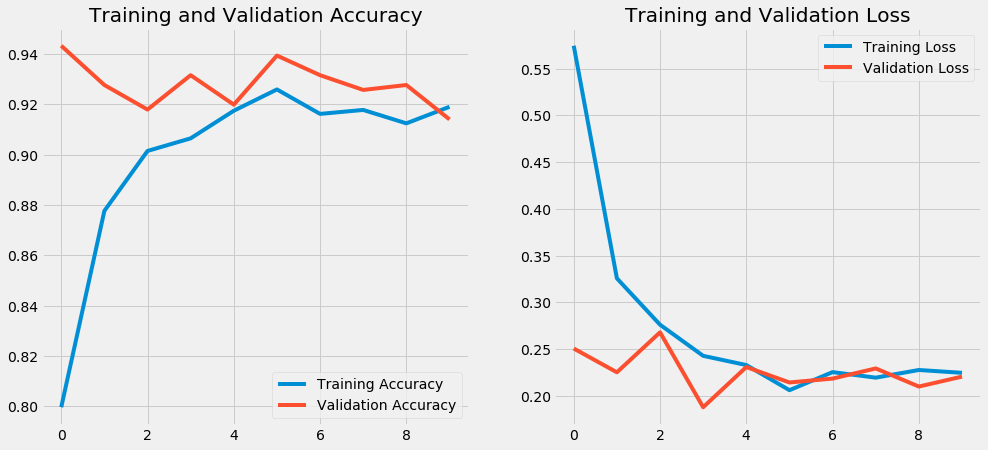

In [34]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
preds = None
true_y = None
for i,j in test_img_generator:
    print(len(i))
    print(len(np.round(model.predict(i))))
    preds = np.round(model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])
print(confusion_matrix(one_class_true_y, one_class_preds))
print(recall_score(one_class_true_y, one_class_preds))
print(accuracy_score(one_class_true_y, one_class_preds))

624
624
[1, 1, 0, 0, 1, 1, 0, 0, 1, 0]
[1, 1, 0, 0, 1, 1, 0, 0, 1, 0]
[[218  16]
 [ 27 363]]
0.9307692307692308
0.9310897435897436


In [36]:
base_model.trainable = True

In [37]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [38]:
EPOCHS = 20
history = model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)
#model.save(MODEL_FILE)

Epoch 1/20
200/200 [==============================] - 45s 216ms/step - loss: 0.1953 - recall: 0.9248 - accuracy: 0.0469 - val_loss: 0.1398 - val_recall: 0.9590 - val_accuracy: 0.1533
Epoch 2/20
200/200 [==============================] - 43s 212ms/step - loss: 0.1098 - recall: 0.9611 - accuracy: 0.1440 - val_loss: 0.1162 - val_recall: 0.9707 - val_accuracy: 0.2090
Epoch 3/20
200/200 [==============================] - 43s 212ms/step - loss: 0.0984 - recall: 0.9653 - accuracy: 0.1538 - val_loss: 0.2376 - val_recall: 0.9004 - val_accuracy: 0.0811
Epoch 4/20
200/200 [==============================] - 43s 213ms/step - loss: 0.0960 - recall: 0.9658 - accuracy: 0.1314 - val_loss: 0.1299 - val_recall: 0.9473 - val_accuracy: 0.2305
Epoch 5/20
200/200 [==============================] - 43s 213ms/step - loss: 0.0927 - recall: 0.9644 - accuracy: 0.1783 - val_loss: 0.2401 - val_recall: 0.9180 - val_accuracy: 0.1846
Epoch 6/20
200/200 [==============================] - 42s 211ms/step - loss: 0.0525 -

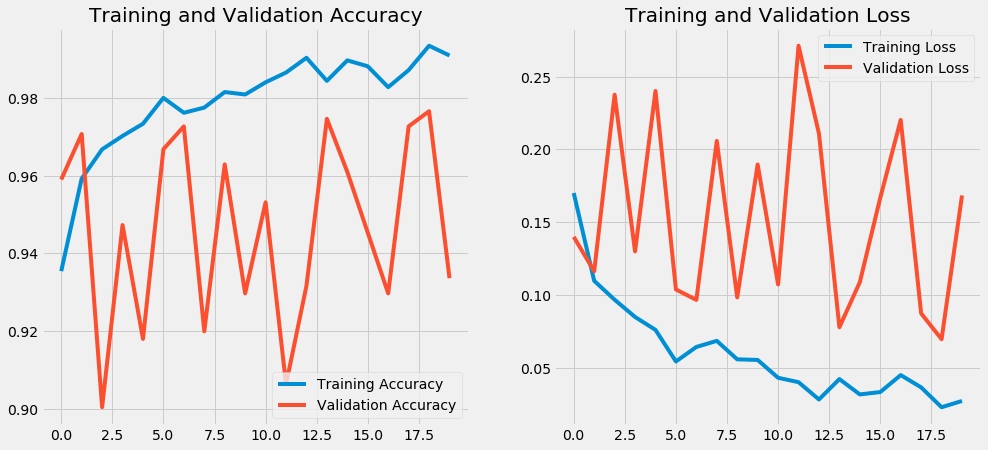

In [39]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
preds = None
true_y = None
for i,j in test_img_generator:
    print(len(i))
    print(len(np.round(model.predict(i))))
    preds = np.round(model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])
print(confusion_matrix(one_class_true_y, one_class_preds))
print(recall_score(one_class_true_y, one_class_preds))
print(accuracy_score(one_class_true_y, one_class_preds))

624
624
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[[229   5]
 [ 17 373]]
0.9564102564102565
0.9647435897435898


In [68]:
#model.evaluate(test_img_generator, batch_size=16, verbose=2)

In [44]:
new_model = Sequential()

In [45]:
new_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3)))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(2,activation='softmax'))

In [47]:
metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()]
new_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)
#new_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0000001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [48]:
EPOCHS = 30
STEPS_PER_EPOCH = 128
VALIDATION_STEPS = 64
history = new_model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)

Epoch 1/30
128/128 [==============================] - 33s 250ms/step - loss: 4.6089 - recall_2: 0.6811 - accuracy: 0.0000e+00 - val_loss: 4.4067 - val_recall_2: 0.7705 - val_accuracy: 0.0000e+00
Epoch 2/30
128/128 [==============================] - 32s 248ms/step - loss: 4.4129 - recall_2: 0.7161 - accuracy: 0.0000e+00 - val_loss: 4.3172 - val_recall_2: 0.7588 - val_accuracy: 0.0000e+00
Epoch 3/30
128/128 [==============================] - 32s 252ms/step - loss: 4.3178 - recall_2: 0.7538 - accuracy: 0.0000e+00 - val_loss: 4.2091 - val_recall_2: 0.7822 - val_accuracy: 0.0000e+00
Epoch 4/30
128/128 [==============================] - 32s 247ms/step - loss: 4.2618 - recall_2: 0.8012 - accuracy: 0.0000e+00 - val_loss: 4.1093 - val_recall_2: 0.8965 - val_accuracy: 0.0000e+00
Epoch 5/30
128/128 [==============================] - 32s 251ms/step - loss: 4.1968 - recall_2: 0.8109 - accuracy: 0.0000e+00 - val_loss: 4.0790 - val_recall_2: 0.8789 - val_accuracy: 0.0000e+00
Epoch 6/30
128/128 [=====

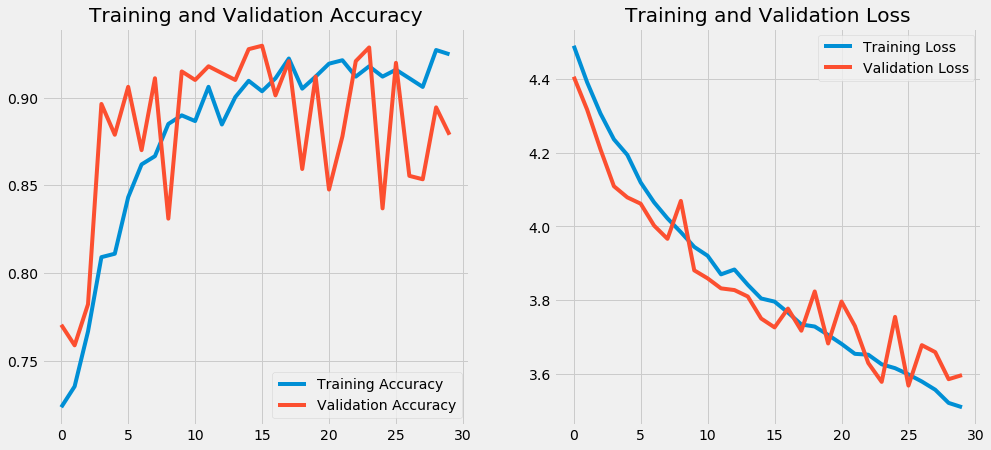

In [50]:
acc = history.history['recall_2']
val_acc = history.history['val_recall_2']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
preds = None
true_y = None
for i,j in test_img_generator:
    #print(len(i))
    #print(len(np.round(new_model.predict(i))))
    preds = np.round(new_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])
print(confusion_matrix(one_class_true_y, one_class_preds))
print(recall_score(one_class_true_y, one_class_preds))
print(accuracy_score(one_class_true_y, one_class_preds))

[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[[210  24]
 [ 30 360]]
0.9230769230769231
0.9134615384615384


In [55]:
preds

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [52]:
preds = None
true_y = None
for i,j in test_img_generator:
    #print(len(i))
    #print(len(np.round(new_model.predict(i))))
    #preds = np.round(new_model.predict(i))
    preds = new_model.predict(i)
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])

[0, 1, 0, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0]


In [53]:
preds

array([[9.9186748e-01, 8.1325592e-03],
       [9.0358622e-04, 9.9909639e-01],
       [1.0807982e-02, 9.8919195e-01],
       ...,
       [5.3987134e-04, 9.9946016e-01],
       [9.9306363e-01, 6.9363778e-03],
       [9.7841632e-01, 2.1583624e-02]], dtype=float32)

In [54]:
def img_class_thresh(cl, thresh):
    if cl[0] > thresh:
        return 0
    else:
        return 1

In [57]:
preds = None
true_y = None
for i,j in test_img_generator:
    #print(len(i))
    #print(len(np.round(new_model.predict(i))))
    preds = new_model.predict(i)
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class_thresh(i,0.7) for i in preds]
print(one_class_preds[:10])
print(confusion_matrix(one_class_true_y, one_class_preds))
print(recall_score(one_class_true_y, one_class_preds))
print(accuracy_score(one_class_true_y, one_class_preds))

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
[[204  30]
 [ 26 364]]
0.9333333333333333
0.9102564102564102
